# 条件GAN：基于文本限制的图片的生成

整体架构如下所示
![image](png/condGAN.png)

> 图片来在Victor Huang

In [1]:
import sys
sys.path.insert(0, '..')
import os
import torch
import random
from torch import optim
from argparse import Namespace
from utils import weights_init_normal, create_demo, create_c_demo
from solver import CondGANSolver
from model import CondGAN, bce_loss, ls_loss
from dataset import cond_anime_loader

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import utils

In [3]:
# 数据集+选择GAN类型
root = os.path.join(os.path.expanduser('~'), 'data/mlds')
gan = 'DCGAN'

In [4]:
# 参数设置
config = {'batch_size': 256, 'epochs': 300, 'use_cuda': True, 'z_size': 100,
          'save_img_step': 1, 'resume': '', 'verbosity': 1, 'data_dir': root,
          'dis_iter': 1, 'seed': random.randint(1, 10000),
          'gan': gan, 'a': 0, 'b': 1, 'c': 1, 'clip': 0.01, 'valid': True, 'val_step': 200,
          'save_dir': '../pretrained/3_2/' + gan, 'save_freq': 50, 'save_grad': False,
          'visdom': False, 'visdom_iter': True}
config = Namespace(**config)
model = CondGAN(name='Cond' + config.gan, use_sigmoid=config.gan == 'DCGAN')
model.apply(weights_init_normal)

CondGAN(
  (G): DCGAN_G(
    (fc): Linear(in_features=22, out_features=64, bias=True)
    (main): Sequential(
      (0): ConvTranspose2d(164, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
      (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace)
      (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (11): ReLU(inplace)
      (12): ConvTranspose2d(128, 

In [ ]:
# 训练阶段  --- 可能需要花费几个小时！, 请耐心等待～
# ---友情提示: 你也可以直接使用提供的已训练好的模型, 那么你就别运行这部分了 ---
if config.gan == 'DCGAN':
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0002, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0002, betas=(0.5, 0.999))}
    criterion = bce_loss
elif config.gan == 'LSGAN':
    config.a, config.b, config.c = 0, 1, 1
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0001, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0001, betas=(0.5, 0.999))}
    criterion = ls_loss
elif config.gan == 'WGAN':
    config.dis_iter, config.clip = 5, 0.01
    optimizer = {'D': optim.RMSprop(model.D.parameters(), lr=0.00005),
                 'G': optim.RMSprop(model.G.parameters(), lr=0.00005)}
    criterion = None
elif config.gan == 'WGAN-GP':
    config.dis_iter, config.penalty = 5, 10
    optimizer = {'D': optim.Adam(model.D.parameters(), lr=0.0001, betas=(0.5, 0.999)),
                 'G': optim.Adam(model.G.parameters(), lr=0.0001, betas=(0.5, 0.999))}
    criterion = None

train_loader = cond_anime_loader(root, config.batch_size)
solver = CondGANSolver(model, optimizer, criterion, [], train_loader, None, config)
solver.train()

头发颜色 ['black', 'blue', 'black', 'red', 'black', 'green', 'aqua', 'pink']
眼睛颜色 ['black', 'yellow', 'brown', 'brown', 'aqua', 'blue', 'red', 'purple']


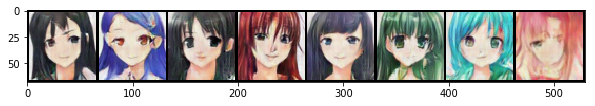

In [7]:
# 可视化
# 说明：
# 1. 头发种类：
hair_color = {0:'aqua', 1:'black', 2:'blonde', 3:'blue', 4:'brown', 5:'gray', 6:'green', 7:'orange', 
              8:'pink', 9:'purple', 10:'red', 11:'white'}
# 2. 眼睛种类：
eye_color = {0:'aqua', 1:'black', 2:'blue', 3:'brown', 4:'green',
             5:'orange', 6:'pink', 7:'purple', 8:'red', 9:'yellow'}
img_num = 8
# ---导入训练好的模型---
checkpoints = torch.load('{}/Cond{}_epoch{}.pth.tar'.format(config.save_dir, gan, config.epochs))
model.load_state_dict(checkpoints['state_dict'])
z = torch.randn(img_num, 100, 1, 1)
hair = [random.randint(0, 11) for _ in range(img_num)]
eye = [random.randint(0, 9) for _ in range(img_num)]
print('头发颜色', [hair_color[i] for i in hair])
print('眼睛颜色', [eye_color[i] for i in eye])
c = torch.from_numpy(create_c_demo(hair, eye)).float()
img = create_demo(model.G, z, c, use_cuda=True, cond=True)
img = utils.make_grid(img.data, normalize=True)
img = img.cpu().numpy().transpose((1, 2, 0))
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.show()

### 结果分析

1. 大体上还是不错的，只是图片质量并不是很高（只迭代了300次）
2. 感觉头发的效果比眼睛更好